<a href="https://colab.research.google.com/github/lIIIIllIIllll/AI_lab/blob/main/Week_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Text-to-Speech With Tacotron2**

**Preparation**

In [ ]:
!pip3 install deep_phonemizer

  Preparing metadata (setup.py) ... done
  Created wheel for deep_phonemizer: filename=deep_phonemizer-0.0.19-py3-none-any.whl size=33272 sha256=bc7460987a8e890e1e983f05c623616a7839623d2eae7fd817c279a8e1e7d26e
  Stored in directory: /root/.cache/pip/wheels/b9/d7/45/f2ae07184a29327b2a7f93b1f734a936c3a34e57225fca603b
Successfully built deep_phonemizer


In [ ]:
import torch
import torchaudio

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

2.8.0+cu126
2.8.0+cu126
cuda


In [ ]:
import IPython
import matplotlib.pyplot as plt

**Test Processing**

Character-based encoding


In [ ]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)

def text_to_sequence(text):
  text = text.lower()
  return [look_up[s] for s in text if s in symbols]

text = "Hello World! Text to speech!"
print(text_to_sequence(text))

[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15, 2, 11, 31, 16, 35, 31, 11, 31, 26, 11, 30, 27, 16, 16, 14, 19, 2]


In [ ]:
processer = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

text = "Hello World! Text to speech!"
processed, lengths = processer(text)

print(processed)
print(lengths)

tensor([[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15,  2, 11, 31, 16, 35, 31, 11,
         31, 26, 11, 30, 27, 16, 16, 14, 19,  2]])
tensor([28], dtype=torch.int32)


In [ ]:
print([processer.tokens[i] for i in processed[0, : lengths[0]]])

['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '!', ' ', 't', 'e', 'x', 't', ' ', 't', 'o', ' ', 's', 'p', 'e', 'e', 'c', 'h', '!']


Phoneme-based encoding

In [ ]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processer = bundle.get_text_processor()

text = "Hello World! Text to speech!"
with torch.inference_mode():
  processed, lengths = processer(text)

print(processed)
print(lengths)

100%|██████████| 63.6M/63.6M [00:02<00:00, 26.7MB/s]


tensor([[54, 20, 65, 69, 11, 92, 44, 65, 38,  2, 11, 81, 40, 64, 79, 81, 11, 81,
         20, 11, 79, 77, 59, 37,  2]])
tensor([25], dtype=torch.int32)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
print([processer.tokens[i] for i in processed[0, : lengths[0]]])

['HH', 'AH', 'L', 'OW', ' ', 'W', 'ER', 'L', 'D', '!', ' ', 'T', 'EH', 'K', 'S', 'T', ' ', 'T', 'AH', ' ', 'S', 'P', 'IY', 'CH', '!']


**Spectrogram Generation**

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


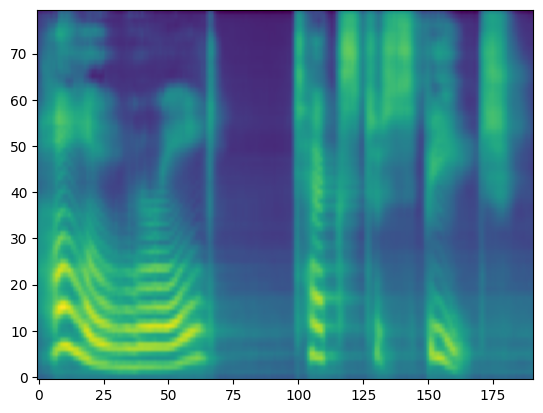

In [ ]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
procsser = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = "Hello World! Text to speech!"

with torch.inference_mode():
  processed, lengths = processer(text)
  processed = processed.to(device)
  lengths = lengths.to(device)
  spec, _,_ = tacotron2.infer(processed, lengths)

_ = plt.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

torch.Size([80, 171])
torch.Size([80, 182])
torch.Size([80, 160])


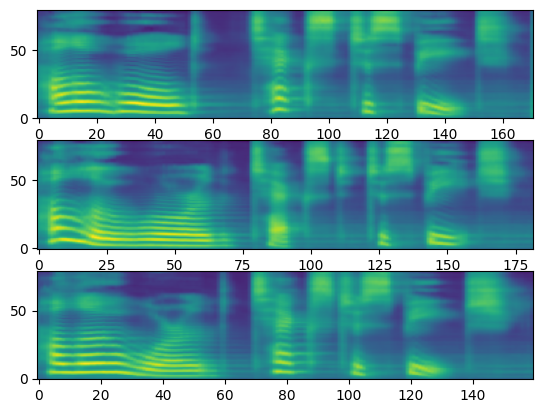

In [ ]:
def plot():
  fig, ax = plt.subplots(3, 1)
  for i in range(3):
    with torch.inference_mode():
      spec,spec_lengths, _ = tacotron2.infer(processed, lengths)
    print(spec[0].shape)
    ax[i].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")


plot()

**Waveform Generation**

WaveRNN Vocoder

In [ ]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_CHAR_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "Hello World! TExt to speech!"

with torch.inference_mode():
  processed, lengths = processor(text)
  processed = processed.to(device)
  lengths = lengths.to(device)
  spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
  waveforms, lengths = vocoder(spec, spec_lengths)

Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_characters_1500_epochs_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_characters_1500_epochs_ljspeech.pth


100%|██████████| 107M/107M [00:01<00:00, 56.5MB/s]


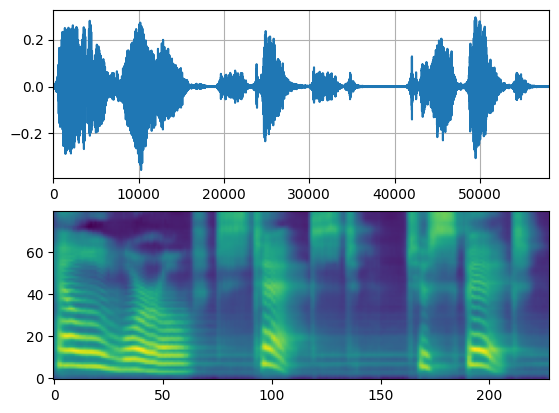

In [ ]:
def plot(waveforms, spec, sample_rate):
  waveforms = waveforms.cpu().detach()

  fig, [ax1, ax2] = plt.subplots(2,1)
  ax1.plot(waveforms[0])
  ax1.set_xlim(0, waveforms.size(-1))
  ax1.grid(True)
  ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
  return IPython.display.Audio(waveforms[0:1], rate=sample_rate)

plot(waveforms, spec, vocoder.sample_rate)

Griffin-Lim Voceder

In [ ]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_CHAR_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
  processed, lengths = processor(text)
  processed = processed.to(device)
  lengths = lengths.to(device)
  spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
waveforms, lengths = vocoder(spec, spec_lengths)

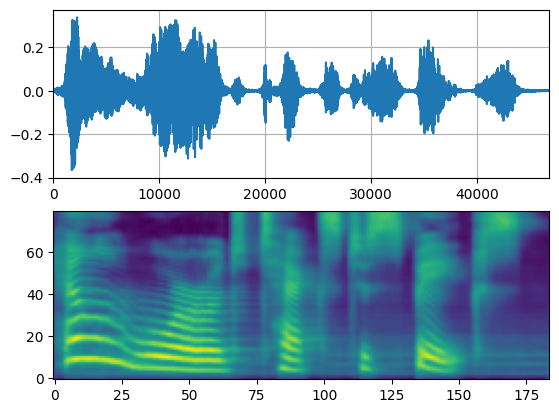

In [ ]:
plot(waveforms, spec, vocoder.sample_rate)

Waveglow Vocoder

In [ ]:
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(

"https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
  waveforms = waveglow.infer(spec)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth" to /root/.cache/torch/hub/checkpoints/nvidia_waveglowpyt_fp32_20190306.pth


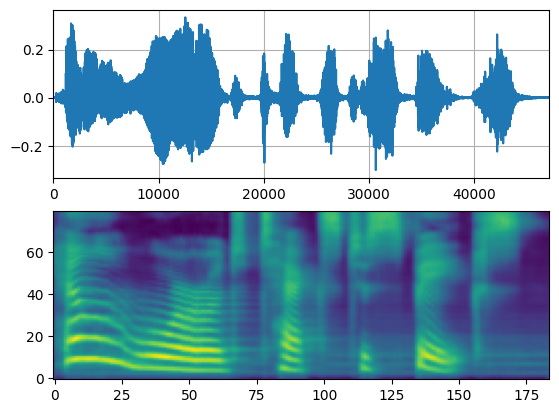

In [ ]:
plot(waveforms, spec, 22050)

**Assignment**

WaveRNN Vocoder

In [ ]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "Hello, my name is Shin Jin-cheol.I'm currently a third-year student in the Department of Software Engineering at Chungbuk National University. My areas of interest are artificial intelligence and embedded systems."

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Downloading: "https://download.pytorch.org/torchaudio/models/wavernn_10k_epochs_8bits_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/wavernn_10k_epochs_8bits_ljspeech.pth


100%|██████████| 16.7M/16.7M [00:00<00:00, 69.5MB/s]


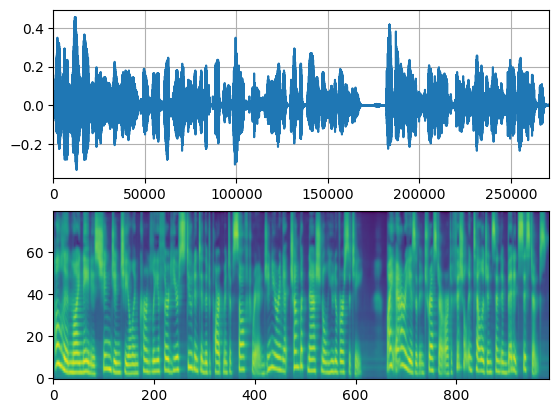

In [ ]:
def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)


plot(waveforms, spec, vocoder.sample_rate)

Griffin_Lim Vocoder

In [ ]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
waveforms, lengths = vocoder(spec, spec_lengths)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_ljspeech.pth


100%|██████████| 107M/107M [00:01<00:00, 66.6MB/s]


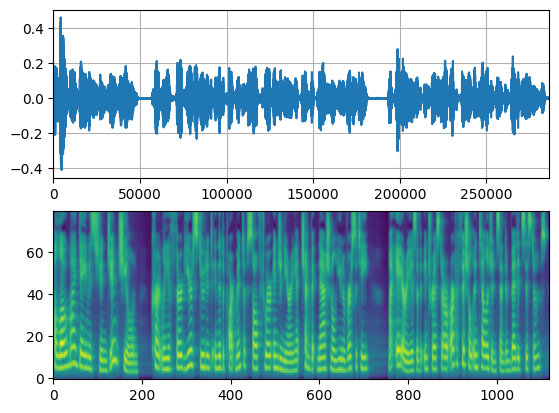

In [ ]:
plot(waveforms, spec, vocoder.sample_rate)

Waveglow Vocoder